# This notebook post-processes data from SolEdge-2D

In [1]:
#!/usr/bin/env python
# Authors: Abdou Diaw (diawa@ornl.gov), Curtis Johnson.
# Copyright (c) 2022-2023 UT-Batelle.
# License: 3-clause BSD.
# """
# plotter for data (x,z) and response surface function(*x)
#   - initalize with x and z (and function)
#   - interpolate if function is not provided
#   - can downsample
#   - plot data and response surface
# """

# class SolEdgePlotter:

In [2]:
# Import necessary libraries
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [3]:
iphi = -1

In [4]:
def refParams(refFileName):
    # reference parameters
    ref=h5py.File(refFileName,'r')
    n0=ref['/n0'][...]
    T0=ref['/T0'][...]
    c0=ref['/c0'][...]
    W0=ref['/W0'][...]
    rho0=ref['/rho0'][...]
    R0=ref['/R0'][...]
    a0=ref['/a0'][...]
    ref.close()
    
    return n0, T0, c0, W0, rho0,R0, a0

def Convert2RealUnits(field, refFileName):
    
    # reference parameters
    n0, T0, c0, W0, rho0,R0, a0 = refParams(refFileName)
    
    if(field[-2:]=='/n'):
        X0 = n0
    elif(field[-2:]=='/T'):
        X0 = T0
    elif(field[-2:]=='/G'):   # parallel velocity
        X0 = n0*c0
    elif(field[-2:]=='/v'):
        X0 = c0
    elif(field[-2:]=='HI'):
        X0 = T0
    elif(field[-2:]=='/W'):
        X0 = W0
    elif(field[-2:]=='Ee'):
        X0 = n0*T0*1.6e-19
    elif(field[-2:]=='Ei'):
        X0 = n0*T0*1.6e-19
    else:
        X0 = 1
        
    return X0

In [5]:

def getWallInfo(meshFileName, refFileName):
    
    # reference parameters
    n0, T0, c0, W0, rho0,R0, a0 = refParams(refFileName)
    # wall and psi
    mesh=h5py.File(meshFileName,'r')
    # meshEIRENE=h5py.File('meshEIRENE.h5','r')
    Rwall=mesh['/wall/R'][...]
    Zwall=mesh['/wall/Z'][...]
    r2D=mesh['/config/r'][...]
    print('r2D',r2D.shape)
    z2D=mesh['/config/z'][...]
    psi2D=mesh['/config/psi'][...]
    psisep=mesh['/config/psisep1'][...]
    #rescale
    R0init=mesh['/R0'][...]
    a0init=mesh['/a0'][...]
    Rwall = (Rwall-R0init)/a0init*a0+R0
    Zwall = (Zwall)/a0init*a0
    r2D = (r2D-R0init)/a0init*a0+R0
    z2D = (z2D)/a0init*a0

    # restrict to points within wall limits
    S=np.shape(r2D)
    for i in range(0,S[0]):
        if(r2D[i,0]>np.min(Rwall)):
            break
    iRmin=i
    for i in range(0,S[0]):
        if(r2D[i,0]>np.max(Rwall)):
            break
    iRmax=i
    for i in range(0,S[1]):
        if(z2D[0,i]>np.min(Zwall)):
            break
    iZmin=i
    for i in range(0,S[0]):
        if(z2D[0,i]>np.max(Zwall)):
            break
    iZmax=i
    r2D=r2D[iRmin:iRmax,iZmin:iZmax]
    z2D=z2D[iRmin:iRmax,iZmin:iZmax]
    psi2D=psi2D[iRmin:iRmax,iZmin:iZmax]
    #mesh.close()
    
    return Rwall, Zwall, r2D, z2D, psi2D,psisep


In [6]:

def getFieldData(field,refFileName,plasmaStateFile,mesh_raptorXFile,fluctuations):
#     fluctuations=0,1,2


    mesh_raptorX=h5py.File(mesh_raptorXFile,'r')
    Nzones = int(mesh_raptorX['/NZones'][...])
    
    data=h5py.File(plasmaStateFile,'r')
    
    X = data['/triangles'+field][...]
    X0= Convert2RealUnits(field, refFileName)
    
    if(fluctuations==1):
        X = X[iphi+1,:] - np.mean(X[:,:],0)
    elif(fluctuations==2):
        X = np.mean(X[:,:],0)
    else:
        X = X[iphi+1,:]
    
    return X*X0, X0


In [7]:
def Plot(field,refFileName,meshFileName, plasmaStateFile,
         mesh_raptorXFile,fluctuations,meshEIRENEFile,plot):
    
    X, X0=getFieldData(field,refFileName,plasmaStateFile,mesh_raptorXFile,fluctuations)
    # colorstyle
    colormap = 'jet'
    #plt.style.use('dark_background')
    #colormap = 'twilight'

    fluctuations = 0 #0 : pp plane, 1: fluctuations, 2: phi average
    logplot = False
    logplotdecades = 3
    # get min max 
    Xmin=1e100
    Xmax=-1e100

    # tune colorbar range (auto if cmin=cmax)
    cmin=0
    cmax=0
    
    meshEIRENE=h5py.File(meshEIRENEFile,'r')
    
    Xmin=min(Xmin,np.min(X))
    Xmax=max(Xmax,np.max(X))

    if(cmin==cmax):
        if(fluctuations==1):
            cmin=min(Xmin,-Xmax)
            cmax=max(Xmax,-Xmin)
        else:
            cmin=Xmin
            cmax=Xmax
        cmin = cmin #*X0
        cmax = cmax #*X0
        if(logplot):
            cmax = int(np.log10(cmax))+1
            cmin = cmax - logplotdecades
    Rwall, Zwall, r2D, z2D, psi2D,psisep=  getWallInfo(meshFileName, refFileName)
    
    if plot=="on":
        fig = plt.figure(figsize=(6,6))
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=cmin, vmax=cmax))
        # plot
        triKnots = meshEIRENE['/triangles/tri_knots'][...]
        Rk = meshEIRENE['/knots/R'][...]
        Zk = meshEIRENE['/knots/Z'][...]


        levels=np.arange(cmin,cmax,(cmax-cmin)/50)
        levels=np.append(levels,cmax*2)
        tri1=plt.tripcolor(Rk/100, Zk/100, triKnots.T-1,
                           facecolors=X,
                           cmap=colormap,vmin=cmin,vmax=cmax)


        cbar = plt.colorbar(sm)
        

        plt.plot(Rwall,Zwall,'-')

        plt.contour(r2D,z2D,psi2D,levels=[psisep[0]])

        spec=float(field[5:6]) 
        if spec == 0.0:
             species = 'electron'
        elif spec == 1.0:
            species = 'D'
        elif spec == 2.0:
            species = 'O'
        elif spec == 3.0:
            species = '$0^{+}$'
        elif spec == 4.0:
            species = '$0^{2+}$'
        elif spec == 5.0:
            species = '$0^{3+}$'
        elif spec == 6.0:
            species = '$0^{4+}$'   
        elif spec == 7.0:
            species = '$0^{5+}$'
        elif spec == 8.0:
            species = '$0^{6+}$'
        elif spec == 9.0:
            species = '$0^{7+}$'
        else:
            print('Element does not exist in the plasma file!')

        plt.title(species)


        plt.xlim([np.min(Rwall),np.max(Rwall)])
        plt.ylim([np.min(Zwall),np.max(Zwall)])

        plt.xlabel(r'$R$ [m]')
        plt.ylabel(r'$Z$ [m]')

        if(field[-1:]=='n'):
            cbar.set_label(str(field[-1:])+' [$m^{-3}$]')
        elif(field[-1:]=='T'):
            cbar.set_label(str(field[-1:])+' [eV]')
        elif(field[-1:]=='G'):   # parallel velocity
            cbar.set_label(str(field[-1:])+' [$m^{-2}$/s]')
        elif(field[-1:]=='v'):
             cbar.set_label(str(field[-1:])+' [m/s]')
        elif(field[-1:]=='Ee'):
             cbar.set_label(str(field[-1:])+' [Pa]')
        elif(field[-1:]=='Ei'):
            cbar.set_label(str(field[-1:])+' [Pa]')
        else:
            print('Unknown field')

        plt.axis('scaled')

        #plt.savefig('PlasmaTri.png',dpi=600)
        plt.show()
    
    return r2D, z2D, X, psi2D, Rwall, Zwall

# Let us now take a closer look at SolEdge data

In [8]:
###  The file contains electron, deuterium, O (Z=0,7) - overall 10 species.

n_species=10
Species_names = [f"/spec{i}/" for i in range(n_species)]
Fields_names = ["G", "n", "T"]   # G is current density [m2/s], n density [1/m3], and T temperature [eV]

In [9]:
### Loading SolEdge files
path='/Users/42d/WEST/SOLEDGEx/'
mesh_raptorXFile=path+'mesh_raptorX.h5'
meshFileName=path+'mesh.h5'
refFileName=path+'refParam_raptorX.h5'
meshEIRENEFile=path+'meshEIRENE.h5'
plasmaStateFile = path+'plasma_00010.h5'
fluctuations=0

In [10]:
!pwd

/Users/42d/WEST/output


r2D (300, 300)


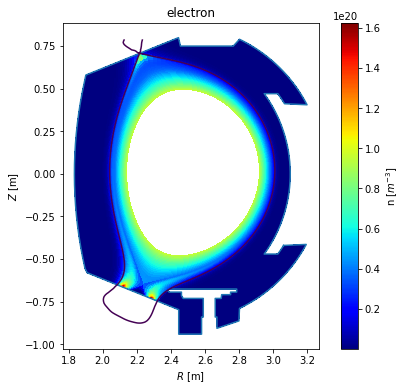

r2D (300, 300)


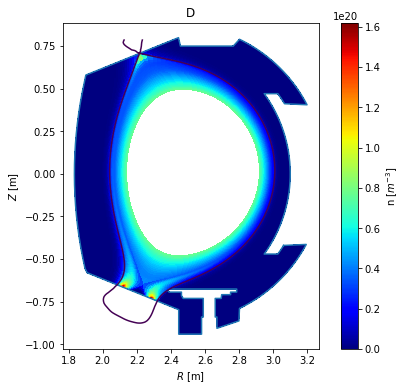

In [11]:
for species in Species_names[0:2]:
    var=species+Fields_names[1]
    Plot(var,refFileName,meshFileName,plasmaStateFile,mesh_raptorXFile,fluctuations,meshEIRENEFile,plot='on')

r2D (300, 300)


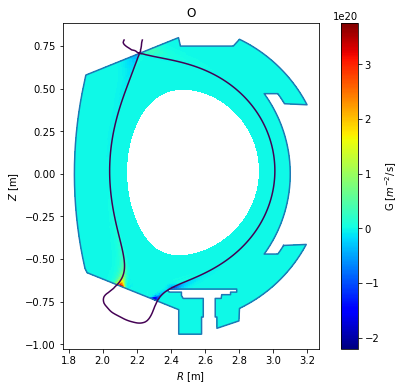

r2D (300, 300)


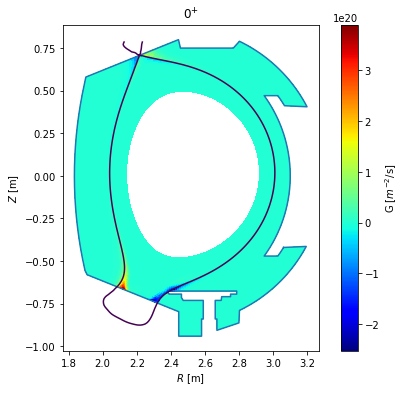

r2D (300, 300)


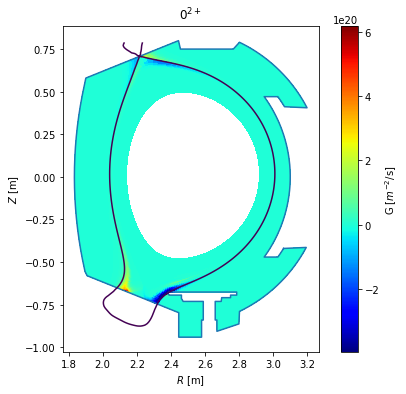

r2D (300, 300)


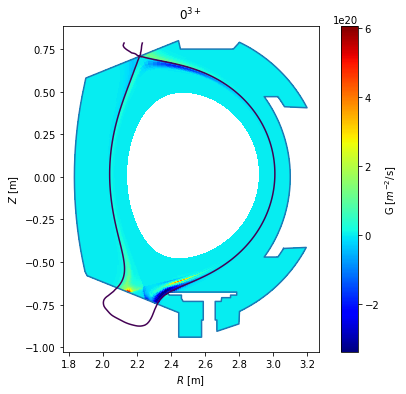

r2D (300, 300)


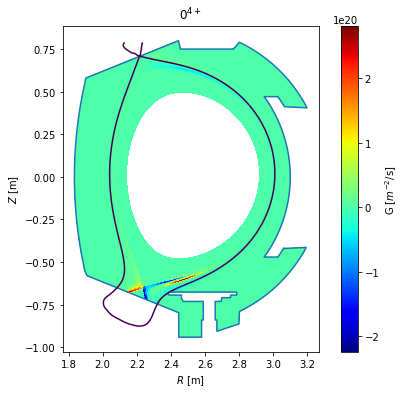

r2D (300, 300)


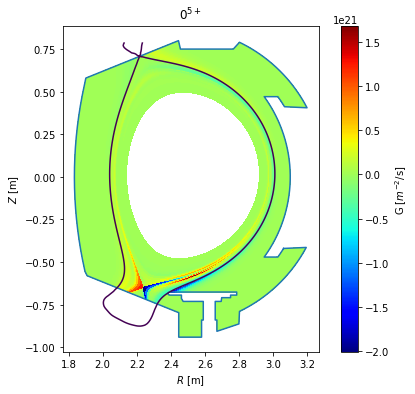

r2D (300, 300)


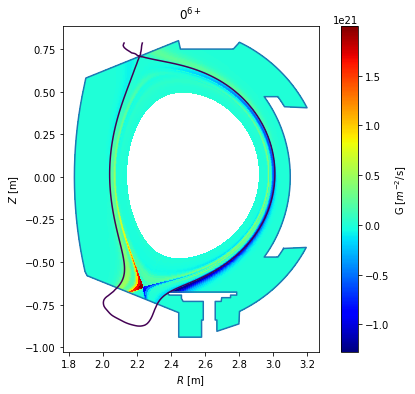

In [12]:
# Plotting results

for species in Species_names[2:9]:
    var=species+Fields_names[0]
    Plot(var,refFileName,meshFileName,plasmaStateFile,mesh_raptorXFile,fluctuations,meshEIRENEFile,plot='on')

In [13]:
### Creating a particle source file

In [14]:
# var=Species_names[0]+Fields_names[1]
# var
# r2D, z2D, X,psi2D,Rwall, Zwall = Plot(var,refFileName,meshFileName,plasmaStateFile,mesh_raptorXFile,fluctuations,meshEIRENEFile,plot='off')

In [15]:
# # plt.contour(r2D, z2D, psi2D, levels=[psisep[0]])
# data=np.loadtxt('Separatrix.csv')
# # plt.plot(data.T[0], data.T[1], 'o')
# # data = [x in data for data.T[1] <0.6]
# x=data[data.T[1] < 0.68] # and 2. < data.T[0] < 2.3 ]
# # x=data[data.T[1] > -0.7] # and 2. < data.T[0] < 2.3 ]
# # x=data[data.T[1] > -] # and 2. < data.T[0] < 2.3 ]

# plt.plot(x.T[0], x.T[1], 'o')
# plt.plot(Rwall,Zwall,'-')

In [16]:
# L2 = []
# for (a,b) in x:
#   if b > -.5 or a>2.35:
#     L2.append((a,b))




In [17]:
# for (a,b) in x:
#   if b > -.4:
#     L2.append((a,b))



In [18]:
# xx=[L2[i][0] for i in range(len(L2))]
# yy=[L2[i][1] for i in range(len(L2))]


In [19]:
# # plt.plot(x.T[0], x.T[1], 'o')
# plt.plot(xx,yy, 'ro')
# plt.plot(Rwall,Zwall,'-')

In [20]:
# import csv 
# cs = plt.contour(r2D, z2D,psi2D,levels=[psisep[0]])

# #data=[Rwall,Zwall,Z]
# with open("Separatrix.csv", 'w') as testfile:
#     csv_writer = csv.writer(testfile,delimiter=' ')
#     for item in cs.collections:
#        for i in item.get_paths():
#           v = i.vertices
#           x = v[:, 0]
#           y = v[:, 1]
#           data=[x,y]  
#           for yd in range(len(data[0])):
#                csv_writer.writerow([xx[yd] for xx in data])
#     #       print(x, y)
# plt.show()

In [21]:
# data=np.loadtxt('Separatrix.csv')

In [22]:
# data=[xx,yy]
# with open("Separatrix.csv", 'w') as testfile:
#    csv_writer = csv.writer(testfile,delimiter=' ')
#    for y in range(len(data[0])):
#        csv_writer.writerow([x[y] for x in data])

In [23]:
# !pwd

In [24]:
# psi2D

In [25]:
data=h5py.File(plasmaStateFile,'r')


In [35]:
izone=1
for izone in range(16):
#     data['/zone'+str(izone+1)+'/ExB'].keys()
    print(izone, np.unique(data['/zone'+str(izone+1)+'/ExB/psi'][...]))

0 [0.]
1 [0.]
2 [0.]
3 [0.]
4 [0.]
5 [0.]
6 [0.]
7 [0.]
8 [0.]
9 [0.]
10 [0.]
11 [0.]
12 [0.]
13 [0.]
14 [0.]
15 [0.]


array([0.])

In [26]:
#       uEtheta = data['/zone'+str(izone+1)+'/ExB/theta'][...]
#         uBtheta = data['/zone'+str(izone+1)+'/spec1/uGradB/theta'][...]
#         b2 = metric['/zone'+str(izone+1)+'/b2'][...]